In [ ]:
import tensorflow as tf

In [ ]:
def conv_block(input_size, filters):
  x= tf.keras.Sequential([
      tf.keras.layers.Conv2D(filters,3,padding = 'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.Conv2D(filters, 3, padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
  ])(input_size)

  return x

In [ ]:
def unet_plus(input=(256,256,3), num_classes=1, deep_supervision = True):
  input_shape= tf.keras.layers.Input(shape=input)

  #encoding
  x_00 = conv_block(input_shape,64)
  x_10 = conv_block(tf.keras.layers.MaxPool2D()(x_00), 128)
  x_20 = conv_block(tf.keras.layers.MaxPool2D()(x_10), 256)
  x_30 = conv_block(tf.keras.layers.MaxPool2D()(x_20), 512)
  x_40 = conv_block(tf.keras.layers.MaxPool2D()(x_30), 1024)

  #skip connection

  x_01 = conv_block(tf.keras.layers.concatenate([x_00, tf.keras.layers.UpSampling2D()(x_10)]), 64)
  x_11 = conv_block(tf.keras.layers.concatenate([x_10, tf.keras.layers.UpSampling2D()(x_20)]), 128)
  x_21 = conv_block(tf.keras.layers.concatenate([x_20, tf.keras.layers.UpSampling2D()(x_30)]), 256)
  x_31 = conv_block(tf.keras.layers.concatenate([x_30, tf.keras.layers.UpSampling2D()(x_40)]), 512)

  x_02 = conv_block(tf.keras.layers.concatenate([
      x_00,x_01,tf.keras.layers.UpSampling2D()(x_11)]), 64)
  x_12 = conv_block(tf.keras.layers.concatenate([x_10,x_11, tf.keras.layers.UpSampling2D()(x_21)]), 128)
  x_22 = conv_block(tf.keras.layers.concatenate([x_20,x_21, tf.keras.layers.UpSampling2D()(x_31)]), 256)

  x_03 = conv_block(tf.keras.layers.concatenate([
      x_00,x_01,x_02, tf.keras.layers.UpSampling2D()(x_12)
  ]), 64)
  x_13 = conv_block(tf.keras.layers.concatenate([
      x_10,x_11,x_12, tf.keras.layers.UpSampling2D()(x_22)
  ]), 128)

  x_04 = conv_block(tf.keras.layers.concatenate([
      x_00,x_01,x_02,x_03,tf.keras.layers.UpSampling2D()(x_13)
  ]),64)


  if deep_supervision:
    output = [
        tf.keras.layers.Conv2D(num_classes,1)(x_01),
        tf.keras.layers.Conv2D(num_classes,1)(x_02),
        tf.keras.layers.Conv2D(num_classes,1)(x_03),
        tf.keras.layers.Conv2D(num_classes,1)(x_04)
    ]
  else:
    output = tf.keras.layers.Conv2D(num_classes,1)(x_04)


  model = tf.keras.Model(inputs=input_shape, outputs= output, name = 'unet_plus')

  return model



model = unet_plus()
model.summary()


Model: "unet_plus"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_45 (Sequential)  (None, 256, 256, 64)         39232     ['input_4[0][0]']             
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 128, 128, 64)         0         ['sequential_45[0][0]']       
 ng2D)                                                                                            
                                                                                                  
 sequential_46 (Sequential)  (None, 128, 128, 128)        222464    ['max_pooling2d_12[0][

In [ ]:
model = unet_plus(input=(512, 512, 3), num_classes=2, deep_supervision=True)
model.summary()

Model: "unet_plus"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 sequential_60 (Sequential)  (None, 512, 512, 64)         39232     ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_16 (MaxPooli  (None, 256, 256, 64)         0         ['sequential_60[0][0]']       
 ng2D)                                                                                            
                                                                                                  
 sequential_61 (Sequential)  (None, 256, 256, 128)        222464    ['max_pooling2d_16[0][

1/1 [==============================] - 25s 25s/step


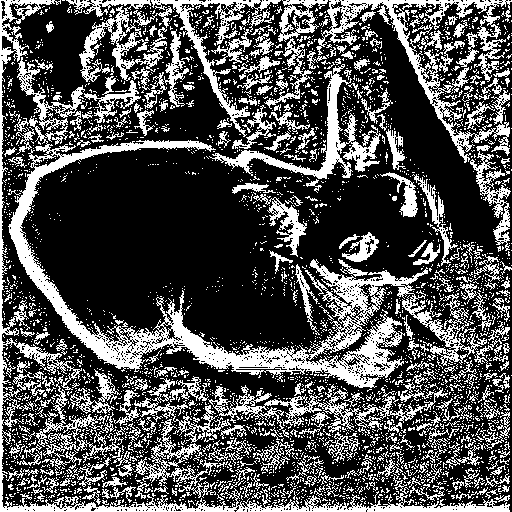

In [ ]:
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image

# Load the image
img = Image.open('/content/cat-(3).png')
# Preprocess the image
img = img.resize((512, 512))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array[:, :, :3], axis=0)
img_array = img_array / 255.

# Load the model
model = unet_plus(input=(
    512, 512, 3), num_classes=2, deep_supervision=False)

# Make predictions
predictions = model.predict(img_array)

# Convert predictions to a numpy array and resize to original image size
predictions = np.squeeze(predictions, axis=0)
predictions = np.argmax(predictions, axis=-1)
predictions = Image.fromarray(np.uint8(predictions*255))
predictions = predictions.resize((img.width, img.height))

# Save the predicted image
predictions.save('predicted_image.jpg')
predictions